In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test pipeline on one instance


In [99]:
from pathlib import Path
import librosa
import IPython.display as ipd
from pitch_estimator import PitchEstimator
import matplotlib.pyplot as plt
import numpy as np
import crepe

import utils as u
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [100]:
# Initialize objects and variables
data_path = Path("gamelan_music_dataset")
targets_first = data_path / "first ensemble/orchestra/target"
audio_file_path = targets_first / "demung/001.wav"
audio_file_path = "audios/ggk1.wav"
pitch_est = PitchEstimator()

# Display input audio
y, sr = librosa.load(audio_file_path, duration=30)
print("Input audio:")
display(ipd.Audio(y, rate=sr))

# Use median filtering to divide harmonic from percussive component
spectrogram = np.abs(librosa.stft(y))
harmonic, percussive = librosa.decompose.hpss(spectrogram, margin=16, kernel_size=31)

# Reconstruct harmonic component audio and display it
harmonic_audio = librosa.griffinlim(harmonic)
print("Harmonic component:")
display(ipd.Audio(harmonic_audio, rate=sr))

# Reconstruct harmonic component audio and display it
percussive_audio = librosa.griffinlim(percussive)
print("Percussive component:")
display(ipd.Audio(percussive_audio, rate=sr))

Input audio:


Harmonic component:


Percussive component:


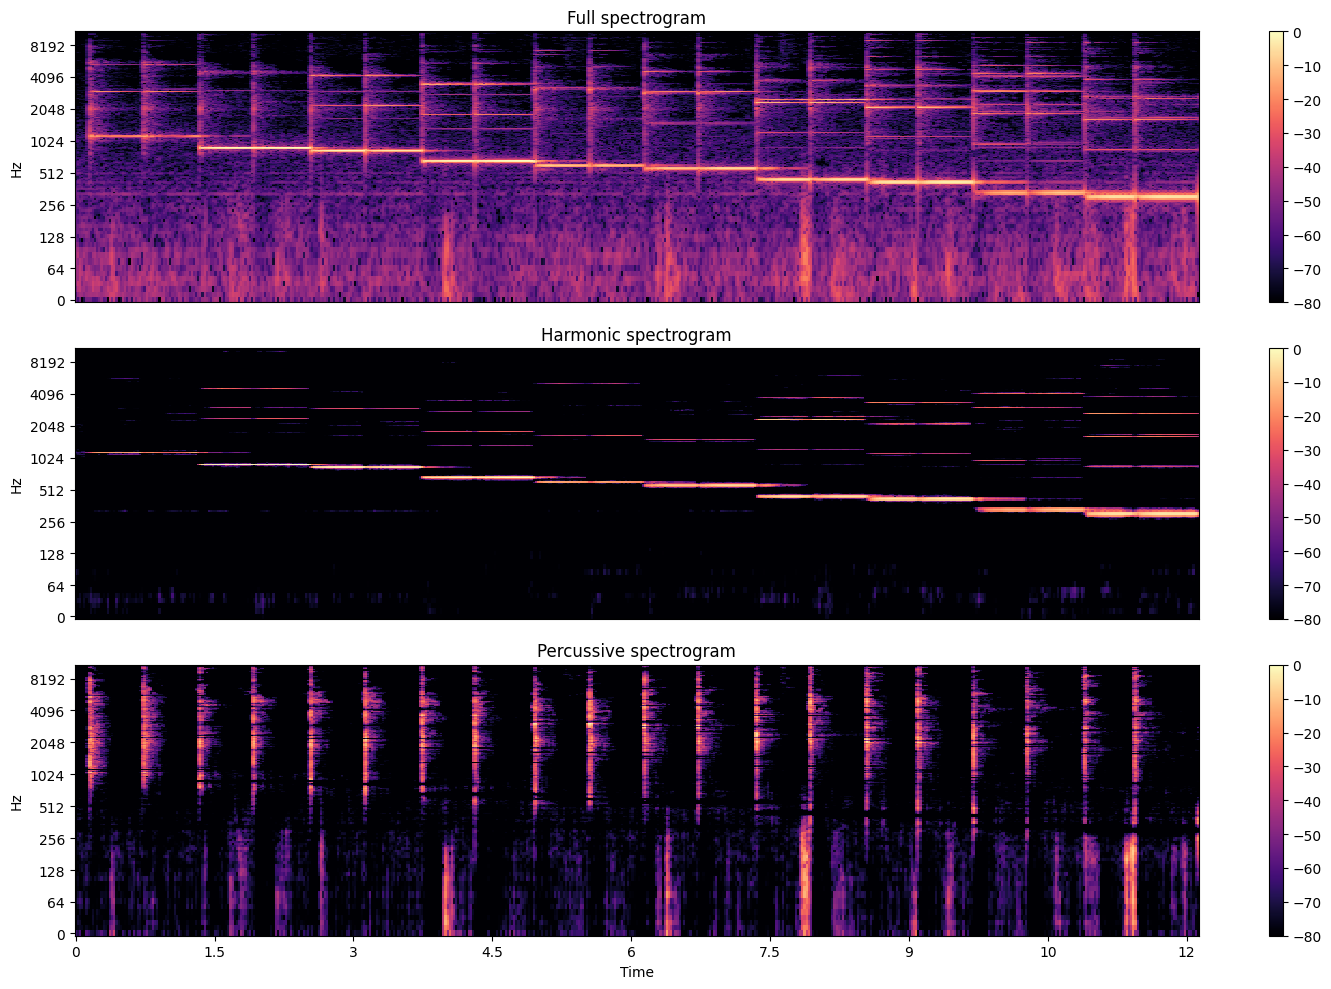

In [101]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Full spectrogram")

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(harmonic), ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Harmonic spectrogram")

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(percussive), ref=np.max), y_axis="log", x_axis="time")
plt.colorbar()
plt.title("Percussive spectrogram")
plt.tight_layout()

plt.show()

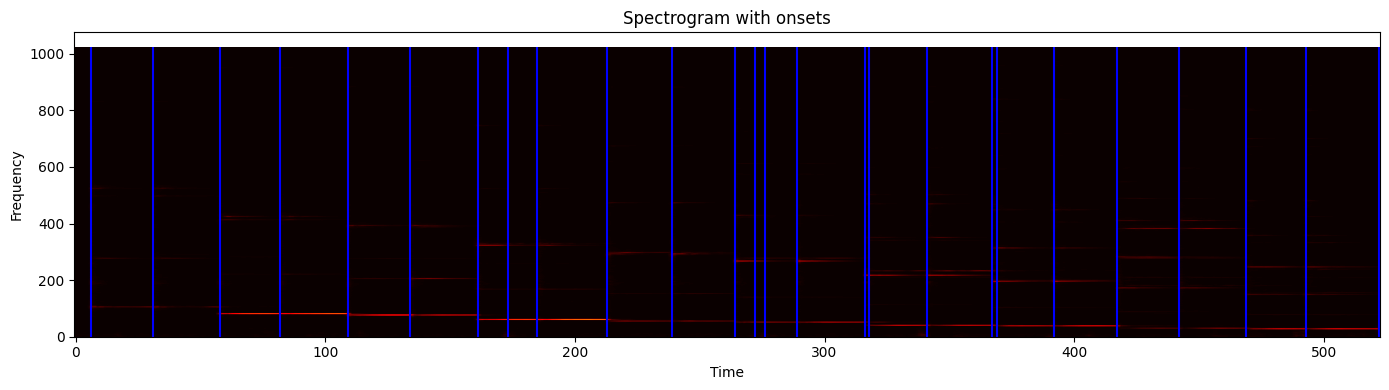

In [102]:
onset_indexes = librosa.onset.onset_detect(y=percussive_audio, sr=sr)

# Create subplots
fig, ax = plt.subplots(figsize=(14, 4))

# Plot the spectrogram
ax.imshow(spectrogram, aspect="auto", origin="lower", cmap="hot")

# Plot vertical lines at onset indices
for onset_index in onset_indexes:
    ax.vlines(onset_index, 0, spectrogram.shape[0], color="blue", linestyle="-")

# Set labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Frequency")
ax.set_title("Spectrogram with onsets")

# Adjust the layout
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

In [103]:
onsets = librosa.onset.onset_detect(y=percussive_audio, units="time")

In [104]:
time, frequency, confidence, activation = crepe.predict(harmonic_audio, sr, viterbi=False)

38/38 [==============================] - 20s 531ms/step


In [105]:
new_frequency = frequency.copy()
new_frequency[confidence < 0.5] = 0

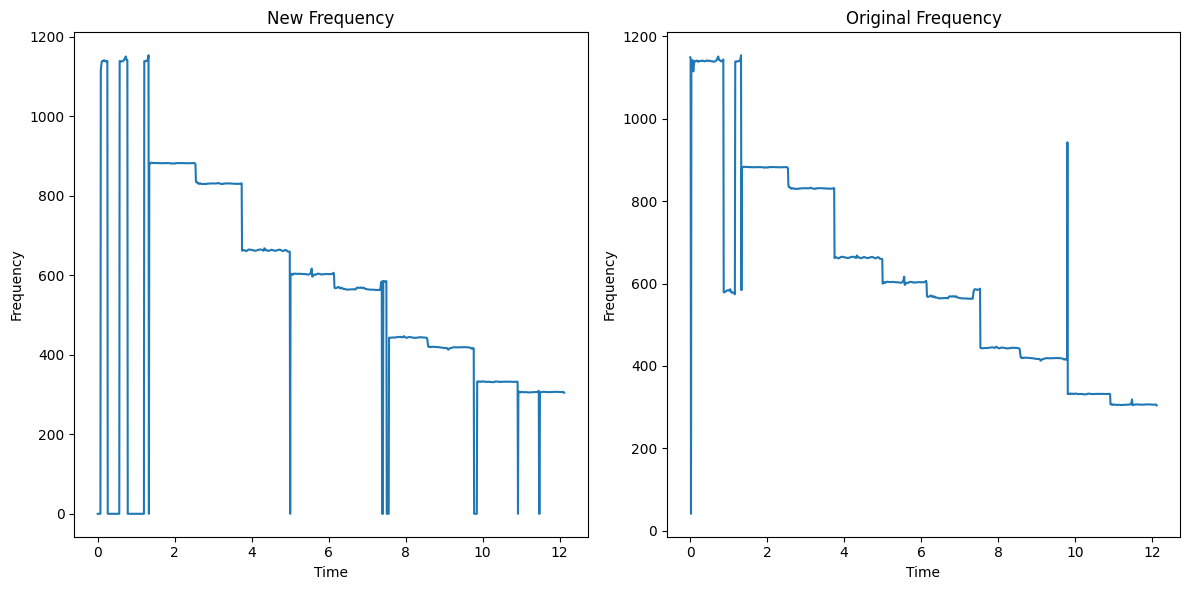

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot new_frequency
ax1.plot(time, new_frequency)
ax1.set_xlabel("Time")
ax1.set_ylabel("Frequency")
ax1.set_title("New Frequency")

# Plot frequency
ax2.plot(time, frequency)
ax2.set_xlabel("Time")
ax2.set_ylabel("Frequency")
ax2.set_title("Original Frequency")

plt.tight_layout()
plt.show()

In [107]:
tones = []
stable_segments_idxs = []


for i, onset in enumerate(onsets):
    index_a = np.argmax(time > onset)
    if i == len(onsets) - 1:
        index_b = len(time) - 1
    else:
        index_b = np.argmax(time > onsets[i + 1])

    frequency_segment = new_frequency[index_a:index_b]

    # tone = np.median(frequency_segment[frequency_segment != 0])
    tone = np.median(frequency_segment)
    if tone == 0:
        continue
    print(f"Onset median {i}-{i+1}: {tone}")
    print(f"Onset mean {i}-{i+1}: {np.mean(frequency_segment)}", "\n")

    print("----------")
    tones.append(tone)

Onset median 2-3: 882.2253876020288
Onset mean 2-3: 882.2822824650477 

----------
Onset median 3-4: 882.0608266617791
Onset mean 3-4: 881.9858866773744 

----------
Onset median 4-5: 830.9418395259385
Onset mean 4-5: 831.8368666037107 

----------
Onset median 5-6: 830.6198127801099
Onset mean 5-6: 830.6601803444166 

----------
Onset median 6-7: 663.4035204205809
Onset mean 6-7: 669.1837465050123 

----------
Onset median 7-8: 663.2722592327723
Onset mean 7-8: 663.371994309977 

----------
Onset median 8-9: 662.7701673239715
Onset mean 8-9: 662.8847850477543 

----------
Onset median 9-10: 603.4516448179928
Onset mean 9-10: 597.9838068025421 

----------
Onset median 10-11: 603.0146897910006
Onset mean 10-11: 603.1570979148878 

----------
Onset median 11-12: 568.6229404004288
Onset mean 11-12: 570.6154502268215 

----------
Onset median 12-13: 566.927650707054
Onset mean 12-13: 567.1223465263519 

----------
Onset median 13-14: 564.4574178821463
Onset mean 13-14: 564.5507672494225 


/home/stef/uni/mir/.mir/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stef/uni/mir/.mir/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


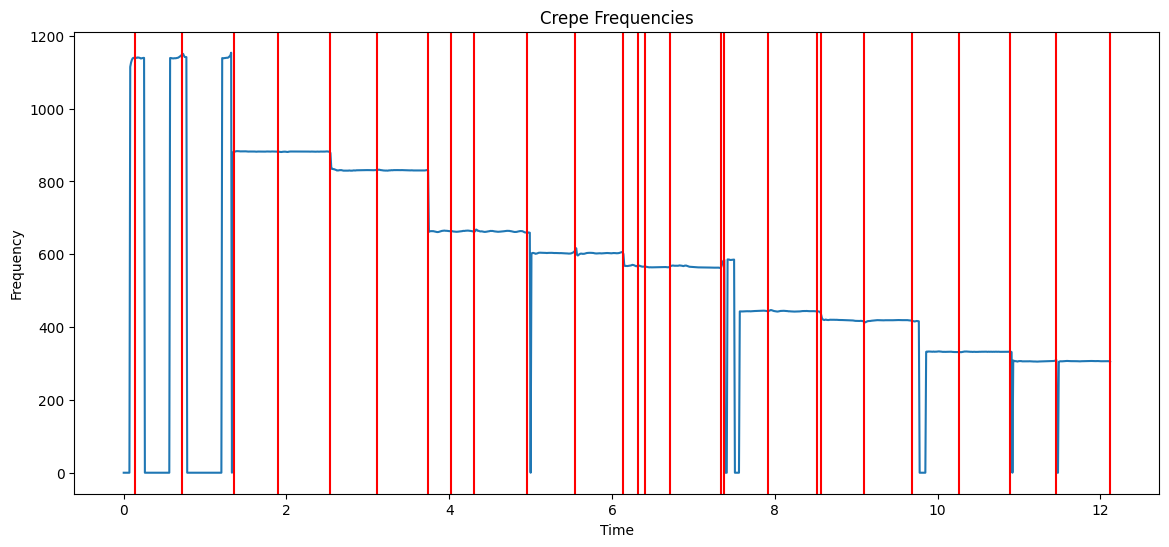

In [108]:
plt.figure(figsize=(14, 6))  # Adjust the size as needed

# Plot the interpolated frequencies
plt.plot(time, new_frequency)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Crepe Frequencies")

for t in onsets:
    plt.axvline(x=round(t, 2), color="r", linestyle="-", label=f"Time {t}")

In [109]:
tone_group = u.group_and_average_frequencies(tones)
print(tone_group)

[305.96614370007944, 332.2352198184437, 419.05548060899935, 443.43247997378086, 565.8435628446747, 579.2025946118647, 603.2331673044966, 663.1486489924415, 830.7808261530242, 882.1431071319039, nan]


In [110]:
for tone in tone_group:
    audio = librosa.tone(tone, duration=1)
    print(f"Playing tone {tone}")
    display(ipd.Audio(audio, rate=sr))

Playing tone 305.96614370007944


Playing tone 332.2352198184437


Playing tone 419.05548060899935


Playing tone 443.43247997378086


Playing tone 565.8435628446747


Playing tone 579.2025946118647


Playing tone 603.2331673044966


Playing tone 663.1486489924415


Playing tone 830.7808261530242


Playing tone 882.1431071319039


Playing tone nan


/home/stef/uni/mir/.mir/lib/python3.11/site-packages/IPython/lib/display.py:175: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


## Find out the tuning


In [111]:
def compute_distance(tone_a, tone_b):
    distance_in_cents = 1200 * np.log2(tone_b / tone_a)
    return distance_in_cents


distances = []
for i in range(len(tone_group) - 1):
    tone_a = tone_group[i]
    tone_b = tone_group[i + 1]
    d = compute_distance(tone_a, tone_b)
    print(f"Distance between {tone_a} and {tone_b}: {d} cents")
    distances.append(d)

Distance between 305.96614370007944 and 332.2352198184437: 142.59959696500707 cents
Distance between 332.2352198184437 and 419.05548060899935: 401.92349008648785 cents
Distance between 419.05548060899935 and 443.43247997378086: 97.88782248416616 cents
Distance between 443.43247997378086 and 565.8435628446747: 422.026564378486 cents
Distance between 565.8435628446747 and 579.2025946118647: 40.39777772520658 cents
Distance between 579.2025946118647 and 603.2331673044966: 70.37722642040299 cents
Distance between 603.2331673044966 and 663.1486489924415: 163.93985041522117 cents
Distance between 663.1486489924415 and 830.7808261530242: 390.16274915347753 cents
Distance between 830.7808261530242 and 882.1431071319039: 103.8537578486032 cents
Distance between 882.1431071319039 and nan: nan cents


In [112]:
for i in range(len(distances) - 1):
    if distances[i] < 220 and distances[i + 1] < 220:
        print(f"Found two consecutive values smaller than 220: {distances[i]} and {distances[i+1]}")
        scale = tone_group[i : i + 6]
        scale_distances = np.array(distances[i : i + 5])
        ding, dong, deng, dung, dang, hiding = scale
        break

print("---")
print(f"Ding: {ding}")
print(f"Dong: {dong}")
print(f"Deng: {deng}")
print(f"Dung: {dung}")
print(f"Dang: {dang}")
print(f"Hiding: {hiding}")
print("---")
print(f"Scale distances: {scale_distances}")

Found two consecutive values smaller than 220: 40.39777772520658 and 70.37722642040299
---
Ding: 565.8435628446747
Dong: 579.2025946118647
Deng: 603.2331673044966
Dung: 663.1486489924415
Dang: 830.7808261530242
Hiding: 882.1431071319039
---
Scale distances: [ 40.39777773  70.37722642 163.93985042 390.16274915 103.85375785]


In [113]:
begbeg = np.array([120, 114, 432, 81, 453])
sedang = np.array([136, 155, 379, 134, 396])
tirus = np.array([197, 180, 347, 104, 372])

similarity = cosine_similarity([scale_distances], [begbeg, sedang, tirus])[0]
print(f"Cosine similarity to begbeg: {similarity[0]}")
print(f"Cosine similarity to sedang: {similarity[1]}")
print(f"Cosine similarity to tirus: {similarity[2]}")
print("-------")

eucl_distances = euclidean_distances(X=[scale_distances], Y=[begbeg, sedang, tirus])[0]
print(f"Euclidian distance to begbeg: {eucl_distances[0]}")
print(f"Euclidian distance to sedang: {eucl_distances[1]}")
print(f"Euclidian distance to tirus: {eucl_distances[2]}")

Cosine similarity to begbeg: 0.561280589920198
Cosine similarity to sedang: 0.6456839416463496
Cosine similarity to tirus: 0.6056499787449012
-------
Euclidian distance to begbeg: 545.509310492364
Euclidian distance to sedang: 462.08272799214245
Euclidian distance to tirus: 473.12149925540336


In [114]:
def gaussian_kernel(x, y, sigma=100):
    distance_squared = np.sum((x - y) ** 2)
    kernel_value = np.exp(-distance_squared / (2 * sigma**2))
    return kernel_value


for tuning_type in [begbeg, sedang, tirus]:
    print(f"Similarity to {tuning_type}: {gaussian_kernel(scale_distances, tuning_type)}")

Similarity to [120 114 432  81 453]: 3.452419395300167e-07
Similarity to [136 155 379 134 396]: 2.3092044921663508e-05
Similarity to [197 180 347 104 372]: 1.3781304193950537e-05
